<a href="https://colab.research.google.com/github/mahi97/MahiColabs/blob/master/auto_encoder_denoised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float64))

In [0]:
def autoencoder(dimensions=[784, 512, 256, 64]):
  x = tf.placeholder(tf.float64, [None, dimensions[0]], name='x')
  
  # Probability that we will corrupt input.
  # This is the essence of the denoising autoencoder, and is pretty
  # basic.  We'll feed forward a noisy input, allowing our network
  # to generalize better, possibly, to occlusions of what we're
  # really interested in.  But to measure accuracy, we'll still
  # enforce a training signal which measures the original image's
  # reconstruction cost.
  #
  # We'll change this to 1 during training
  # but when we're ready for testing/production ready environments,
  # we'll put it back to 0.
  corrupt_prob = tf.placeholder(tf.float64, [1])
  current_input = corrupt(x) * corrupt_prob + x * (1 - corrupt_prob)
  
  encoder = []
  for layer_i, n_output in enumerate(dimensions[1:]):
      n_input = int(current_input.get_shape()[1])
      W = tf.Variable(
          tf.random_uniform([n_input, n_output],
                            -1.0 / math.sqrt(n_input),
                            1.0 / math.sqrt(n_input), dtype=tf.float64))
      b = tf.Variable(tf.zeros([n_output], dtype=tf.float64))
      encoder.append(W)
      output = tf.nn.tanh(tf.matmul(current_input, W) + b)
      current_input = output

  # %% latent representation
  z = current_input
  encoder.reverse()

  # %% Build the decoder using the same weights
  for layer_i, n_output in enumerate(dimensions[:-1][::-1]):
      W = tf.transpose(encoder[layer_i])
      b = tf.Variable(tf.zeros([n_output], dtype=tf.float64))
      output = tf.nn.tanh(tf.matmul(current_input, W) + b)
      current_input = output

  # %% now have the reconstruction through the network
  y = current_input

  # %% cost function measures pixel-wise difference
  cost = tf.reduce_sum(tf.square(y - x))
  return {'x': x, 'z': z, 'y': y,'corrupt_prob':corrupt_prob, 'cost': cost}

In [0]:
import tensorflow.keras.datasets.mnist as mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
y_test = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_test]
y_train = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_train]

In [5]:
"""Test the autoencoder using MNIST."""
mean_img = np.mean(X_train, axis=0)
ae = autoencoder(dimensions=[784, 256, 64, 32, 16])

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# %%
# Fit all training data
batch_size = 50
n_epochs = 50
for epoch_i in range(n_epochs):
    for batch_i in range(X_train.shape[0] // batch_size):
      batch_xs = X_train[batch_i * batch_size: (batch_i + 1) * batch_size]
      train = np.array([img - mean_img for img in batch_xs]).reshape(batch_size,784)
      sess.run(optimizer, feed_dict={ae['x']: train, ae['corrupt_prob']:[1.0]})
    print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train, ae['corrupt_prob']:[1.0]}))

0 1468.1291982325065
1 1325.9972446165561
2 1291.4953771114106
3 1255.9722549616663
4 1250.9238728587688
5 1231.7805010539628
6 1225.5226546072374
7 1212.6454431315635
8 1196.5852636995126
9 1181.7713051399387
10 1172.921706969
11 1155.5685452516454
12 1132.9731535284886
13 1122.533244575542
14 1125.7903661532812
15 1124.866355023479
16 1113.9023703346247
17 1103.1286810799
18 1081.1367822799755
19 1069.1894139023427
20 1056.0293896290486
21 1059.5781904541793
22 1065.118510940816
23 1048.722439083419
24 1044.9181818588506
25 1065.8837103473047
26 1052.9951221836145
27 1045.9394173392566
28 1036.9934681284938
29 1042.3312040038106
30 1043.961559042895
31 1032.1128518741023
32 1029.8955914745447
33 1033.873480192214
34 1040.2534665130288
35 1039.585676802853
36 1032.0599783700109
37 1035.4519748995494
38 1026.3586687486775
39 1026.3910399863194
40 1034.8967676868567
41 1011.7430355162662
42 1018.8682390592232
43 1031.5112778745797
44 1028.4159223300062
45 1022.8973018011206
46 1021.1021

0


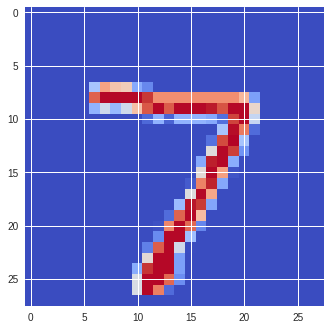

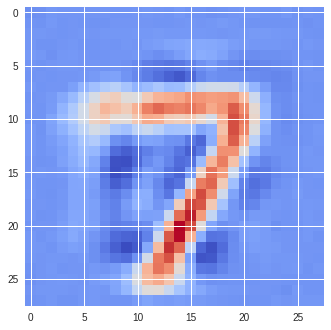

1


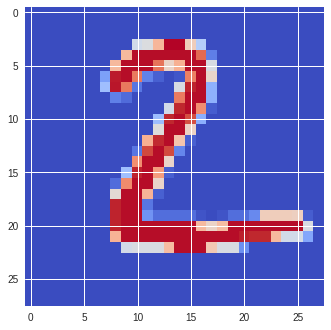

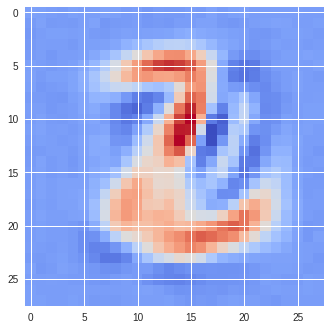

2


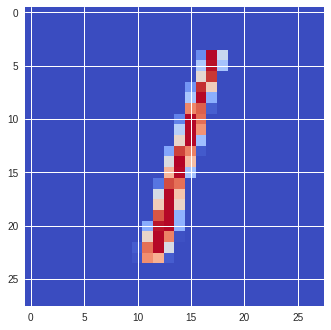

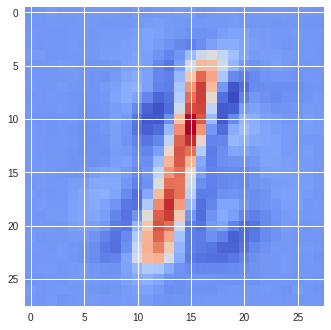

3


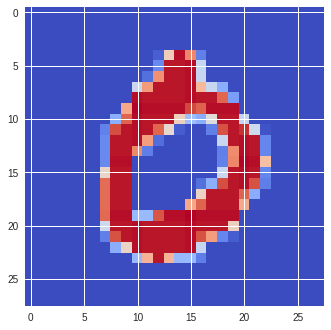

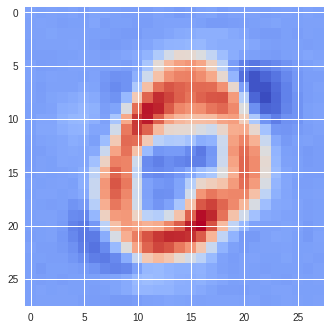

4


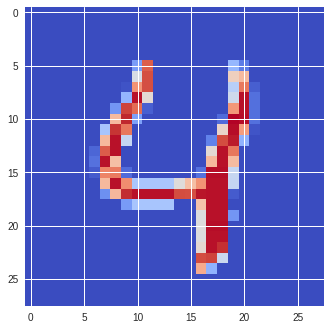

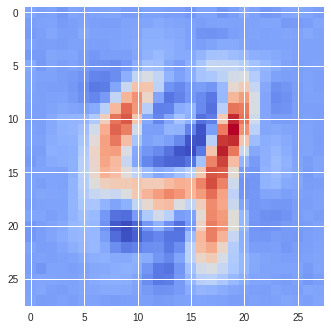

5


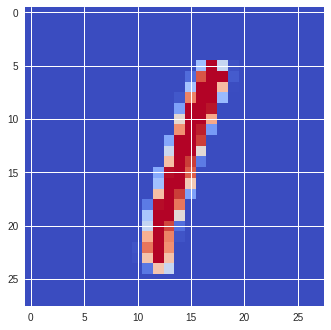

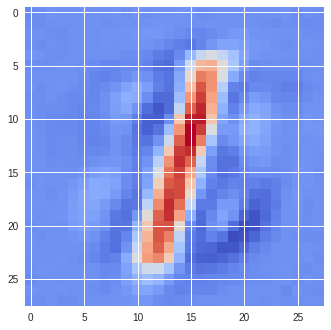

6


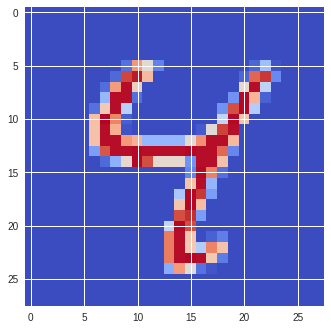

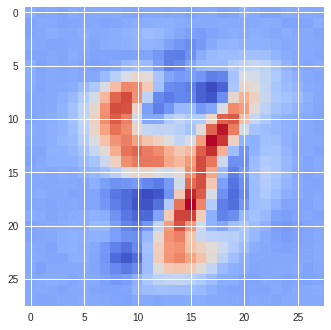

7


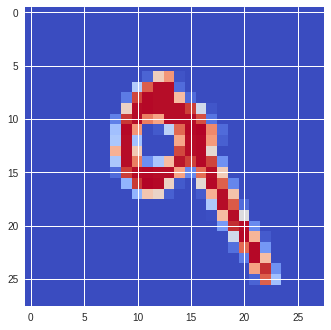

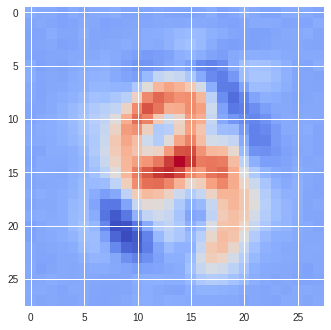

8


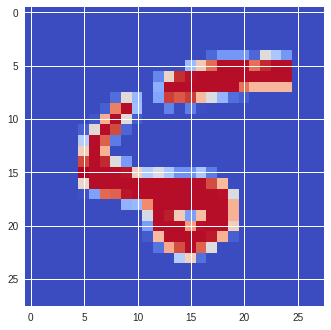

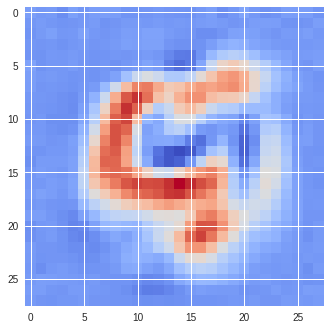

9


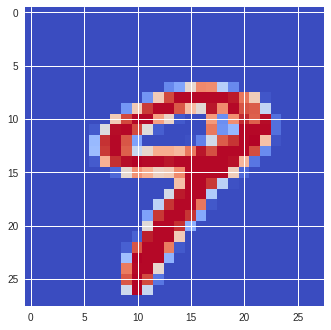

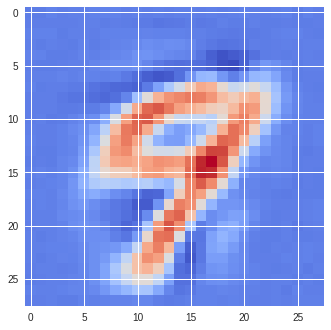

10


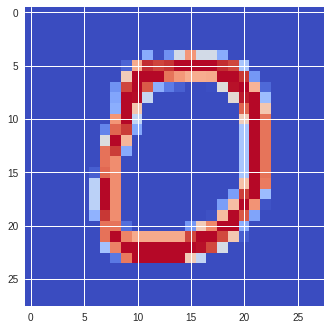

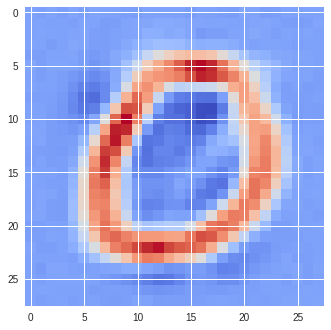

11


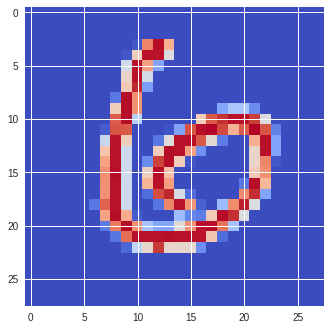

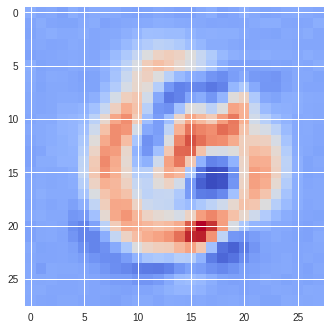

12


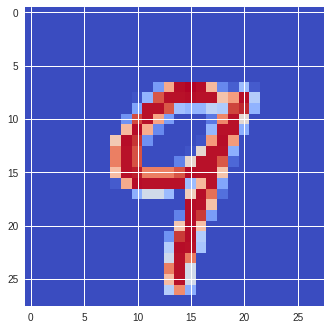

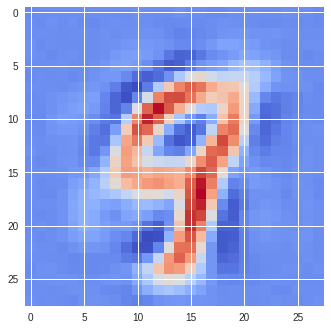

13


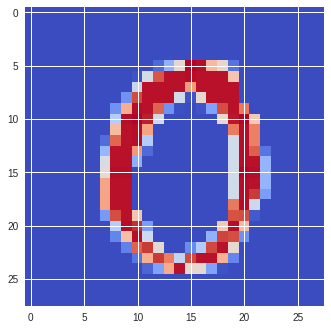

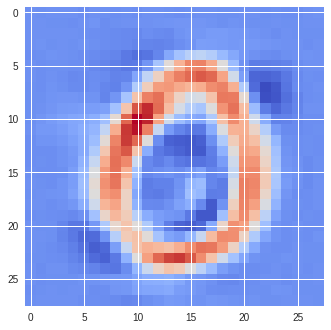

14


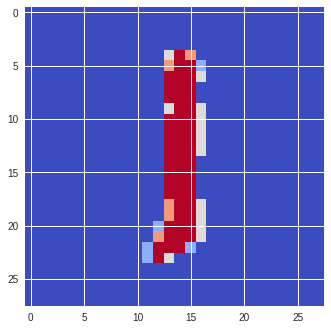

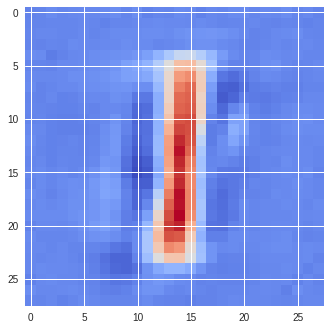

In [7]:
# Plot example reconstructions
n_examples = 15
mean_img = np.mean(X_train, axis=0)
test_xs =X_test[0 * n_examples: (0 + 1) * n_examples]
test_xs_norm = np.array([img - mean_img for img in test_xs]).reshape(n_examples,784)
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm, ae['corrupt_prob']:[0.0]})
for example_i in range(n_examples):
    print(example_i)
    plt.imshow(
        np.reshape(test_xs[example_i, :], (28, 28)), cmap='coolwarm')
    plt.show()
    plt.imshow(
        np.reshape([recon[example_i, :] + mean_img.reshape(784,)], (28, 28)), cmap='coolwarm')
    plt.show()